# **Descriptive Statistics Analysis of Bigfoot Sightings**
 >Enyu Chou, Joy Chow, Jinru Wei, Jasmine Ye
 
 >MA 705








##**Introduction:**


> Bigfoot is an ape-like creature purported to inhabit the forests of North America. While reported Bigfoot sightings throughout the 20th century have consistently aroused curiosity, the world has little understanding of this mysterious being. In this analysis project, our team compiled data from different sources to gain insights into Bigfoot as well as potential trends associated with its sightings. By creating seven visualizations that translated data-driven findings into easily understood representations, not only did we investigate the domestic geographic distribution, time series, and common narrative of Bigfoot sightings, but we also explored the impacts of county-level socioeconomic variables on the likelihood of these sightings.


## **Data Description and Data Cleaning objectives:**

###**Data Description:**

Our initial dataset consists of four files:
> * *bigfoot.csv:*  4,747 records of Bigfoot sightings in the US, with location, a detailed narrative of the report, and a variety of weather conditions of the day.
> * *county_data.csv:* a data frame of all US counties, the state to which it belongs, and county-level demographic and economic information.
> * *county_geo.zip:* detailed geospatial data at the county level for the United States.
> * *county_labels.pkl:* a data frame with each US county’s FIPS (unique identification code), name, the state to which it belongs, and state abbreviation.



###**Data Cleaning Objectives:**

1.   Include continents strictly within the contiguous United States
2.   Remove missing values from and fix inconsistent entries in relevant variables that would be used to solve problems



In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 12.7 MB/s 
     |████████████████████████████████| 6.3 MB 29.3 MB/s 
     |████████████████████████████████| 15.4 MB 48.3 MB/s 


In [ ]:
import re
import geopandas
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import colors as colors
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
county = geopandas.read_file("cb_2018_us_county_5m.shp")
bigfoot = pd.read_csv("bigfoot.csv")
county_data = pd.read_csv("county_data.csv")
county_unpickled = pd.read_pickle("county_labels.pkl")

> ### **Data Preparation**
>After importing the dataset, we first eliminated from the geospatial data all non-contiguous states, including Alaska, Hawaii, and US Territories. For each sighting in the Bigfoot sightings file, we matched it to the corresponding county, represented by a unique identification code (GEOID / FIPS), as per the longitude and latitude where the sighting occurred. According to each county’s GEOID, we only extracted sightings within the contiguous US. 

In [ ]:
county_cleaned = county[county.STATEFP.isin(['02','15','60','66','69','72','78']) == False]
bigfoot_1 = bigfoot.dropna(subset=['latitude','longitude'])
bigfoot_1 = geopandas.GeoDataFrame(bigfoot_1, crs="EPSG:4326", geometry=geopandas.points_from_xy(bigfoot_1.longitude, bigfoot_1.latitude))

In [ ]:
for sighting in bigfoot_1.index:
    is_in_county = [bigfoot_1.geometry[sighting].within(poly) for poly in county_cleaned.geometry]
    county = str(county_cleaned[is_in_county].GEOID.values)

    if any(is_in_county):
       bigfoot_1.loc[sighting, 'FIP'] = county_cleaned[is_in_county].GEOID.values
    else:
       bigfoot_1.loc[sighting, 'FIP'] = "not_contiguous"

In [ ]:
bigfoot_1 = bigfoot_1[bigfoot_1.FIP!="not_contiguous"]
# replace 33019 because of the bracket 
bigfoot_1['FIP'] = bigfoot_1['FIP'].replace(['33019'],'33019')
# bigfoot_1 is a dataframe that matches each sighting to county in the contiguous US
bigfoot_1.to_pickle('bigfoot_cleaned.pkl', protocol = 4)

## **Location Map of Bigfoot Sightings:**

> ### **Methodology:**
> Null values have already been removed from the longitude and latitude columns of the Bigfoot sightings data frame that would be used for this problem. With cleaned data on Bigfoot sightings within the contiguous US, we utilized GeoPandas to identify each report according to the associated longitude and latitude. Each red dot on the map represents one sighting. 


In [ ]:
#########################################
# Map1: Location Map
bigfoot_cleaned = pd.read_pickle("bigfoot_cleaned.pkl")
bigfoot_2 = bigfoot_cleaned
# bigfoot_2 is used for location map
bigfoot_2 = geopandas.GeoDataFrame(bigfoot_2, crs="EPSG:4326", geometry=geopandas.points_from_xy(bigfoot_2.longitude, bigfoot_2.latitude))

(-127.62233794999997, -64.06073105, 23.271492200000004, 50.6278278)

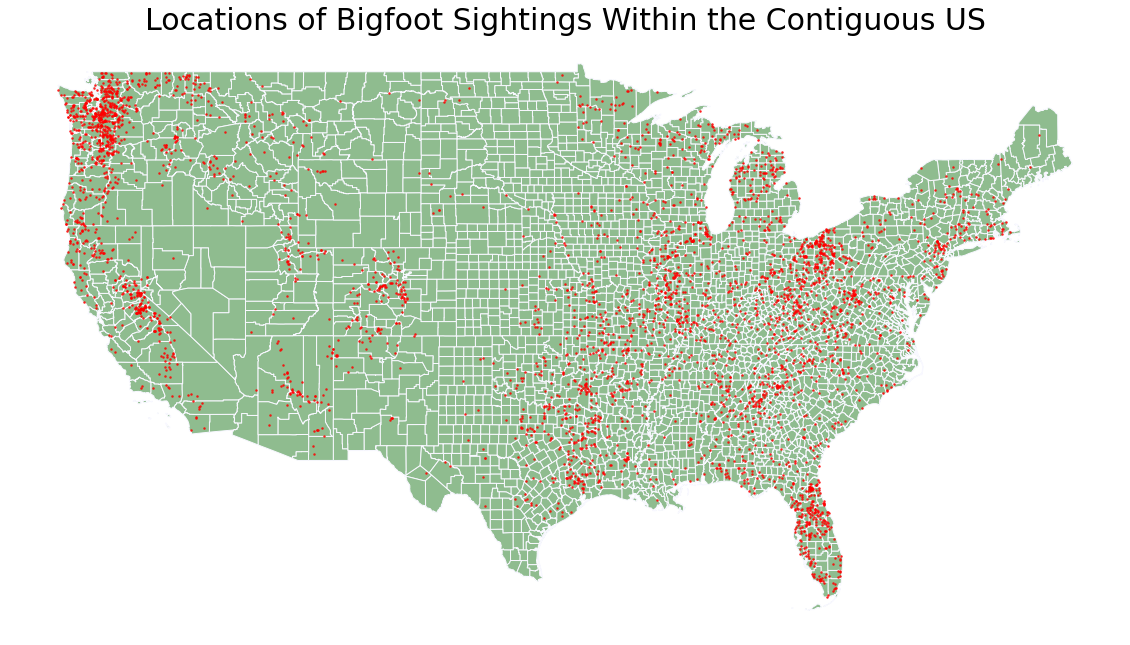

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_facecolor("white")
county_cleaned.plot(ax=ax, color='darkseagreen', edgecolor='ghostwhite')
bigfoot_2.plot(ax=ax, color="red", markersize=10, marker='.', alpha=.7)
ax.set_title("Locations of Bigfoot Sightings Within the Contiguous US", fontsize=30)
ax.axis('off')

> ### **Observations:**
>We were able to observe the distribution of Bigfoot sightings in the Census Regions and Divisions in the United States directory (Exhibit1) and conservatively conclude that these sightings are scattered in counties that belong to the following regions:

>1.   **West Pacific:** Washington (high volume); Oregon; California

>Bigfoot sightings in the West Pacific are highly concentrated around the coast, especially on the northern coast of Washington.

>2.   **West Mountain:** Colorado, Arizona

>There are dense Bigfoot sightings reported within and around Arizona.

>3.   **East North Central:** Ohio (light concentration); Michigan; Illinois

>Bigfoot sightings are evenly distributed all across the East North Central area, with a light concentration in Ohio.

>4. **South Atlantic and East South Central:** Florida (relatively high volume); Georgia; Atlanta

>South Atlantic and East South Central have a relatively high volume of bigfoot sightings. Specifically, Florida has the highest concentrations in the north as well as its coastal areas.

## **Bigfoot Sightings Per County Map:**

### **Methodology:**

>To visualize Bigfoot sightings per county, We counted the number of sightings as per unique FIPS codes because county names for different states may be repeated. Using the results, we constructed a map that reflects the number of sightings reported in each county within the contiguous US. The darker the red is, the more sightings have been reported in the specific county. Vice versa, the lighter the color of the county is, the fewer bigfoot sightings there have been. The maximum number of Bigfoot sightings within a county is 62.

In [ ]:
#########################################
# Map2: Sightings per County
bigfoot_countystate = bigfoot_cleaned.merge(county_unpickled, left_on = "FIP", right_on = "fips", how="left")
removed_columns = ["fips", "location_details", "latitude", "longitude", "date", "number", "temperature_high", "temperature_mid", "temperature_low", "dew_point", "humidity", "cloud_cover", "moon_phase", "precip_intensity", "precip_probability", "precip_type", "pressure", "wind_bearing", "wind_speed", 'summary', 'uv_index', 'visibility'] 
bigfoot_countystate.drop(removed_columns, axis=1, inplace=True)

# count the number of sightings for each FIP because FIP is unique whereas county names may be repeated
sightings_by_county = Counter(bigfoot_countystate.FIP)
sightings_by_county_df = pd.DataFrame.from_dict(sightings_by_county, orient='index').reset_index()
sightings_by_county_df = sightings_by_county_df.rename(columns={'index':'FIP', 0:'sightings'})

county_cleaned['sightings'] = [sightings_by_county[FIP] for FIP in county_cleaned.GEOID]

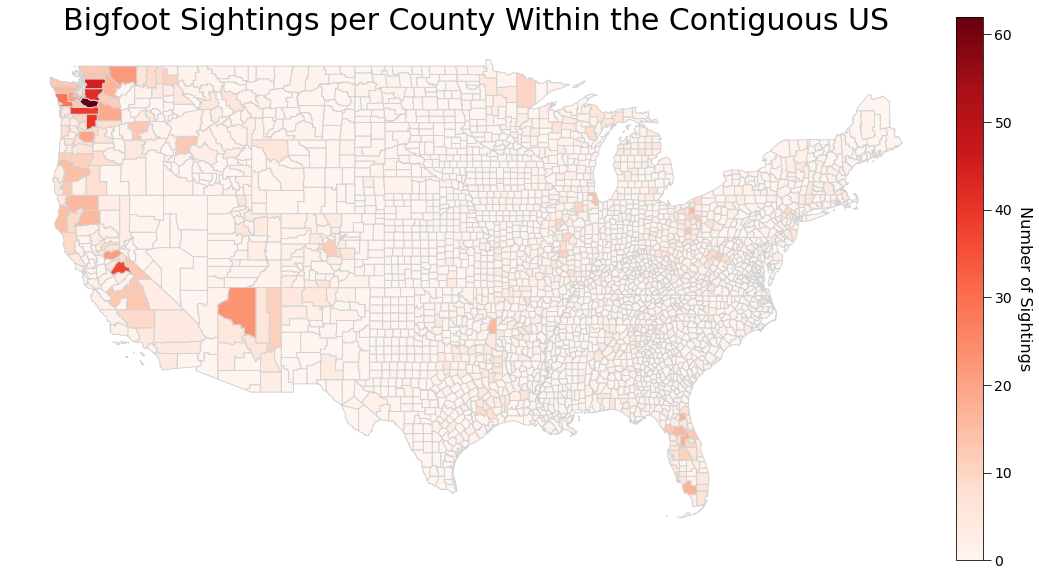

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
county_cleaned.plot(ax=ax, column='sightings', edgecolor='lightgray',
                    cmap="Reds", legend=True,
                    legend_kwds = {'shrink' : .5,
                                   'pad' : .01})
ax.set_facecolor("white")
ax.set_title("Bigfoot Sightings per County Within the Contiguous US", fontsize=30)
ax.axis('off')

cb = fig.axes[1]
cb.set_ylabel("Number of Sightings",  labelpad=20, rotation=270, fontsize=16) 
cb.tick_params(size = 8, labelsize=14)

>In addition, we matched the state and county names to each Bigfoot sighting and created a list of the top 10 counties with the most sightings as well as the state to which they belong respectively.

In [ ]:
# List the top 10 counties with Bigfoot sightings
sightings_by_county_df = sightings_by_county_df.merge(county_unpickled, left_on = "FIP", right_on = "fips", how="left")
sightings_by_county_df = sightings_by_county_df.rename(columns={'state':'state_abb', "state_name":'state'}).drop(["fips","state_abb"], axis=1)

sightings_top10counties = sightings_by_county_df.sort_values("sightings", ascending = False).iloc[:10, :]
print("The top 10 counties with most Bigfoot sightings are:")
print(sightings_top10counties)

The top 10 counties with most Bigfoot sightings are:
        FIP  sightings        county       state
715   53053         62        Pierce  Washington
720   53061         45     Snohomish  Washington
717   53033         42          King  Washington
460   53059         40      Skamania  Washington
711   53041         39         Lewis  Washington
1008  06109         37      Tuolumne  California
724   53027         29  Grays Harbor  Washington
1000  04005         23      Coconino     Arizona
714   53047         22      Okanogan  Washington
713   53045         21         Mason  Washington



> ## **Conclusion:**
>Map 1 shows an overall even distribution of Bigfoot sightings around the West Pacific, West Mountain, East North Central, South Atlantic, and East South Central Area, with higher concentrations in states like Ohio, Arizona, Washington, and Florida. We also found that Bigfoot was most heavily reported in areas near lakes and ocean coasts. Therefore, we suspect that Bigfoot’s habitat preference is strongly associated with water.

>As a supplement, Map 2 serves as a clearer county-level visualization based on the actual number of bigfoot sightings reported. It indicates that while Bigfoot sightings are distributed across the US, Washington is the state with the highest concentration of sightings. We further confirmed our conclusion with a list of the top 10 counties for Bigfoot sightings, as eight out of 10 counties with the most sightings are located in the state of Washington.


> 
##**County-level Comparisons**

###**Data Preparation**


>We first eliminated from the county data file any rows with missing value in the county column. Because the word “county” is not part of the official county name, we also remove the word “county” from the column. 
Due to inconsistent formatting, we modified several entries in the county data (such as “DeKalb” versus “De Kalb” in the county labels file) to prevent mismatches when joining county labels in the next step. 

>One thing worth noting was that the county labels file had FIPS 22117 as Washington county in the Louisiana state, whereas the county data file contained no Washington county in Louisiana but Washington Parish. According to additional research results, FIPS 22117 is the code that identifies Washington Parish. Therefore, we also made changes to this county name. 

>Then, we merged the county data with the sightings by county data frame on both state and county values. We also excluded states and counties that were not in the contiguous US. The final data frame that we used to make comparisons matched the number of Bigfoot sightings in each contiguous US county to county-level demographic and economic statistics. 

>For counties without a matched value for Bigfoot sightings, which meant 0 sightings at all, we filled in 0s to provide a comprehensive plot.


In [ ]:
#########################################
# Comparison 1: Sightings vs. Per Capita Income
# remove rows that have missing values in county
county_data = county_data.dropna(subset = ["county"])
# remove the word "County" from county_data
county_data['county'] = county_data['county'].str.replace(' County', '')
# Due to inconsistent formatting, modify entries in county_data to prevent missing values when joning data
county_data['county'] = county_data['county'].str.replace('St.', 'St')
county_data['county'] = county_data['county'].str.replace('DeKalb', 'De Kalb')
county_data['county'] = county_data['county'].str.replace('DeSoto', 'De Soto')
county_data['county'] = county_data['county'].str.replace('LaSalle', 'La Salle')
county_data['county'] = county_data['county'].str.replace('DeWitt', 'De Witt')
county_data['county'] = county_data['county'].str.replace('DuPage', 'Du Page')
county_data['county'] = county_data['county'].str.replace('Washington Parish', 'Washington')


In [ ]:
# create dataframe that compares sightings and county_level attributes
sighting_features = sightings_by_county_df.merge(county_data, on = ["state", "county"], how="right")
sighting_features = sighting_features.fillna({"sightings": 0})

# keep contiguous US only
non_contiguous_list = ["American Samoa", "District of Columbia", "Puerto Rico", "Guam", "Hawaii", "Alaska", "Northern Mariana Islands", "U.S. Virgin Islands"]
sighting_features = sighting_features[sighting_features.state.isin(non_contiguous_list) == False]
#print(sighting_features.isna().sum())
sighting_features.to_pickle('sighting_features1.pkl', protocol = 4)

###**Methodology**:
>With the new data frame, we intended to construct visualizations that compared the number of Bigfoot sightings to insightful demographic and economic attributes. Therefore, we created two data frames, which focused on the following attributes respectively:
 
>*   Number of sightings vs. Per capita income of the county
>*   Number of sightings vs. Population of the county
 
>Two scatter plots were then created to examine Bigfoot sightings' relationships with these two features, respectively.


In [ ]:
# focus on per capita income and population for comparisons
sighting_features['income_per_cap'] = sighting_features['income_per_cap'].str.replace(",", "").str.replace("$", "")
sighting_features['population'] = sighting_features['population'].str.replace(",", "")

# create a new dataframe for each comparison 
sighting_income = sighting_features.dropna(subset = ["income_per_cap"])
sighting_income['income_per_cap'] = sighting_income['income_per_cap'].astype(int)
sighting_pop = sighting_features.dropna(subset = ["population"])
sighting_pop["population"] = sighting_pop["population"].astype(int)

Text(40000, 30, 'y=0.00003319*x+0.4192')

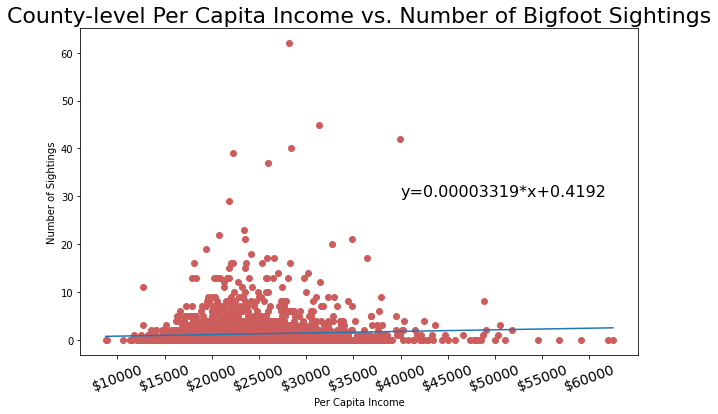

In [ ]:
# compare number of sightings with county_level income per capita
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(sighting_income.income_per_cap, sighting_income.sightings, color='indianred')
plt.xlabel("Per Capita Income")
plt.ylabel("Number of Sightings")
x_labels_income = ["$" + str(tick) for tick in range(10000,65000,5000)]
plt.xticks(range(10000,65000,5000), labels=x_labels_income, rotation=20, fontsize=14)
plt.title("County-level Per Capita Income vs. Number of Bigfoot Sightings", fontsize=22)

model = smf.ols("sightings~income_per_cap", data=sighting_income)
res = model.fit()
#print(res.summary())
plt.plot(sighting_income.income_per_cap, 0.00003319*sighting_income.income_per_cap+0.4192)
plt.text(40000,30,"y=0.00003319*x+0.4192", fontsize=16)


###**Observations of "Number of Reports vs. Per Capita Income":**
>The best fit line of this scatter plot is y=0.00003319*x+0.4192 based on the statistical output. The distribution seems to skew towards the right. We found that counties with the highest numbers of Bigfoot sightings tend to have a per capita income ranging from $17,000 to $32,000. In particular, the county that has most Bigfoot sightings has a $28,000 per capita income. On the other hand, counties with the highest per capita income turn out to have few Bigfoot sightings.


Text(5000000, 20, 'y=0.000001464*x+1.0553')

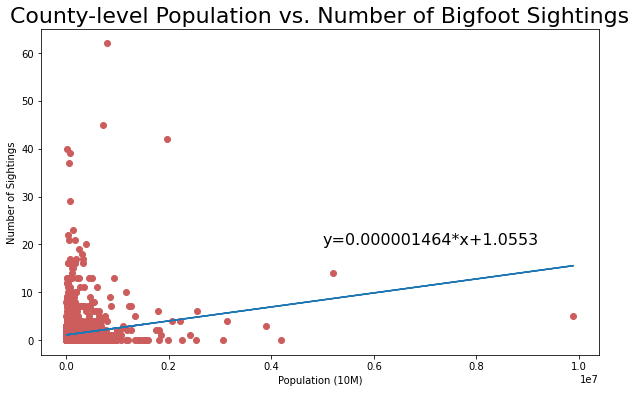

In [ ]:
# compare number of sightings with county_level population
sighting_features['population'] = sighting_features['population'].str.replace(",", "")

sighting_pop = sighting_features.dropna(subset = ["population"])
sighting_pop["population"] = sighting_pop["population"].astype(int)

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(sighting_pop.population, sighting_pop.sightings, color='indianred')
plt.xlabel("Population (10M)")
plt.ylabel("Number of Sightings")
plt.title("County-level Population vs. Number of Bigfoot Sightings", fontsize=22)

model = smf.ols("sightings~population", data=sighting_pop)
res = model.fit()
#print(res.summary())
plt.plot(sighting_pop.population, 0.000001464*sighting_pop.population+1.0553)
plt.text(5000000,20,"y=0.000001464*x+1.0553", fontsize=16)

>
###**Observations of "Number of Reports vs. Population":**
>The best fit line of this scatter plot is y=0.000001464*x+1.0553 based on the statistical output. We observed a significantly right-skewed normal distribution. To further illustrate, counties with smaller populations tend to have more Bigfoot sightings. Counties with the highest numbers of Bigfoot sightings tend to have a population ranging from 800K to 2.2 million. 

>
###**Conclusions drawn from both comparisons:**
>Based on the two comparison graphs above, counties that have relatively lower per capita income and smaller populations tend to have more Bigfoot sightings. This indicates that Bigfoot is more likely to appear in less developed suburbs or rural areas.

##**Time Series Analysis:**

> 
###**Data Preparation**
>After dropping an outlier sighting reported from an old newspaper article, we manually set a four-digit year for each Bigfoot sighting by manipulating the date column of the Bigfoot sightings data frame. All the sightings were from 1921 to 2018. We then counted the number of sightings per year. 

In [ ]:
#########################################
# Bigfoot Sightings Per Year
bigfoot_time=bigfoot.dropna(subset=['date'])
# drop sighting from an old newspaper article
bigfoot_time.loc[bigfoot_time['date'] == '1869-11-10']
bigfoot_time=bigfoot_time.drop(3323)

# extract year from initial data
bigfoot_time[["day", "month", "year"]] = bigfoot_time["date"].str.split("/", expand = True)
YY=bigfoot_time['year']

for i in bigfoot_time.index:
    if int(bigfoot_time.loc[i,'year'])< 19:
        bigfoot_time.loc[i,'four_digit']='20'+bigfoot_time.loc[i,'year']
    else:
        bigfoot_time.loc[i,'four_digit']='19'+bigfoot_time.loc[i,'year']

series=bigfoot_time.groupby("four_digit")['number'].count()
series = series.reset_index()

>
###**Methodology:**

>Since time is a continuous variable, we created a line graph demonstrating the relationship between the number of reports and year.


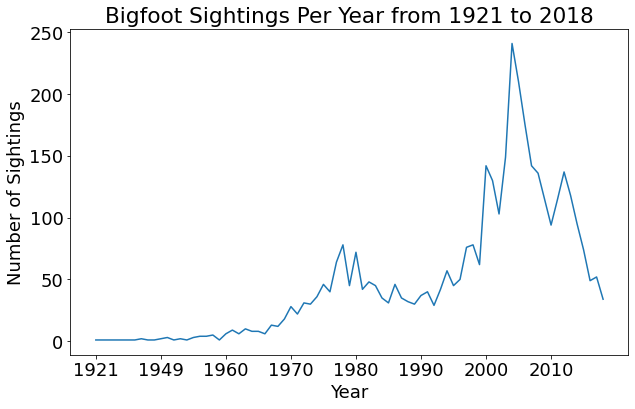

In [ ]:
plt.rc('font', size=18)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(series.four_digit, series.number, color='tab:blue', label='Number')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Sightings')
ax.set_title('Bigfoot Sightings Per Year from 1921 to 2018')
ax.set_xticks(ax.get_xticks()[::10])

> 
###**Observations:**

>We found that there have been more reported Bigfoot sightings in recent years (after 2000) than in the earlier years. There were significant inclines in Bigfoot sightings from 1970 to the early 1980s as well as from 2000 to the early 2010s. In particular, the number peaked in around 2005. After 2010, the number of sightings significantly decreased.

> 
###**Conclusions:**

>Although some variations exist, the time-series graph shows an overall increasing trend of Bigfoot sightings from 1921 to 2018. Notably, there was a spike in reports from the late 1970s through the beginning of the 1980s. Also, there has been a significantly high volume of reports in the early 2010s. We could reasonably associate these two peaks of Bigfoot sightings with the release of the two Bigfoot movies in 1970 and 2012, respectively, which brought people’s attention to this mysterious creature.



##**WordCloud:**

###**Data Preperation:**
> To have a more well-rounded observation of the creature Bigfoot, we utilized the report descriptions of the original bigfoot sightings data for our analysis.


In [ ]:
observations = pd.DataFrame(bigfoot['observed'])

###**Methodology:**

**Appearance:**

>We used for loop to connect all the text in the row under the description column. Then, we use RegEx to parse the sentences, creating a data frame of sentences for the construction of our WordCloud.

 

In [ ]:
# joint all the texts and split them by sentences.
text = []
for observation in observations['observed']:
    text.append(observation)

sentences = pd.DataFrame(str(text).split('.'))
sentences.rename(columns={0:'Sentence'},inplace=True) 

sentences

,Sentence
0,['Ed L
1,was salmon fishing with a companion in Prince...
2,"After anchoring off shore, his companion took..."
3,As the day wore on toward evening and he didn...
4,There he saw a sasquatch walking across the t...
...,...
103368,I decided discretion was the better part of v...
103369,The next morning we went back into the woods ...
103370,Much like a bear does to mark it\'s area
103371,The only thing about it is there are no bears...


> To observe the description of Big Foot, we had chosen a list of keywords to filter out the sentences and construct the "key sentences" data frame: Feet, Arm, Hand, Hair, Leg, Footprint, Height, Eyes, Hairy, Fur.

In [ ]:
# Selecting target sentences including specific key words
keywords = ['feet','arm','hand','hair','leg','footprint','height','eyes','hairy','fur']

key_sentences = []
for sentence in sentences['Sentence']:
    for word in keywords:
        if word in sentence:
            key_sentences.append(sentence)
            
key_sentences = pd.DataFrame(key_sentences).drop_duplicates(keep='first')
key_sentences.rename(columns={0:'Sentence'},inplace=True) 

key_sentences

,Sentence
0,There he saw a sasquatch walking across the t...
1,about 10minutes later i looked into the woods...
2,then i closed my eyes waited a few seconds an...
3,but this whatever it was had difined shoulder...
4,i closed my eyes and tried my hardest just to...
...,...
14103,The creature stood about seven feet tall as I...
14104,He or it was approximately 40 feet from my po...
14106,I could see that he had dark hair covering his...
14108,He ran into the stream and away from me about...


>We further searched the following keywords, which we thought might be near the appearance descriptions of the Bigfoot, and obtained their location in the sentences: 

> “hair, hairy, foot, arm, arms, hand, hands,leg, legs, eye, footprint, face, beard” 

> Then, we cut off the redundant texts by only keeping the former and latter 15 bytes of text around the keywords for the sake of narrowing the target text of our WordCloud construction process.


In [ ]:
# Find the position of specific word using RegEx and obtain the text around it by a length of 15 bytes.
begin_position  = []
key_word = []
narrowed_observation = []
for observation in key_sentences['Sentence']:
    for t in re.finditer('(\w* (hair|hairy|fur|foot|arm|arms|hand|hands|leg|legs|eye|footprint|face|beard) \w*)',str(observation)):
        begin_position.append(t.start())
        key_word.append(t.group(0))
        narrowed_observation.append(observation[int(t.start() - 15):int(t.end() + 15)])
        
narrowed_observation = pd.DataFrame(narrowed_observation)
narrowed_observation.rename(columns={0:'Observation'},inplace=True) 

narrowed_observation

,Observation
0,steps and with dark hair flowing from its shoul
1,was a bear its front arms wouldnt have given it
2,moving with it's arms brush and tree branc
3,ample
4,footprint and a hair sample
...,...
5179,man walking on two legs at a hurried pace
5180,swinging their long arms quickly
5181,int I did feel the hair on the back of my
5182,ee that he had dark hair covering his Conical sh


>To eliminate the effect of incomplete words that suffer from text cutting, we deleted the characters both at the beginning and the end of sentences. This creates the “narrowed_ob” data set.

> Finally, we constructed the WordCloud based on the "narrowed_ob" data frame.

In [ ]:
# Delete the first word (affected by the 15 bytes cut off) of the biginning and the end of row.
narrowed_ob = []
t = 0
for n_ob in narrowed_observation['Observation']:
    try:
        n_ob = n_ob.split(' ', 1)[1]
        n_ob = n_ob.rsplit(' ', 1)[0]
        narrowed_ob.append(n_ob)
    except:
        t += 1
        
narrowed_ob = pd.DataFrame(narrowed_ob)
narrowed_ob.rename(columns={0:'Observation'},inplace=True) 

narrowed_ob

,Observation
0,and with dark hair flowing from its
1,a bear its front arms wouldnt have given it
2,with it's arms brush and tree
3,footprint and a hair
4,could not see a hand because of the
...,...
4356,walking on two legs at a hurried
4357,their long arms
4358,I did feel the hair on the back of
4359,that he had dark hair covering his Conical


> 
###**Weights and Heights:**
>To further investigate the weight and height of Bigfoot, we used the associated keywords with RegEx to locate descriptions of our “key sentences” data frame.

>Height: ft, foot tall, feet tall, ft tall. 

>Weight: lbs, lb, pound, pounds.

>Creating the new data frame “height_and_weight.”  



In [ ]:
# Extract height and weight description separately using specific unit words.
height = []
for observation in key_sentences['Sentence']:
    t = re.findall('(\w+ (ft|ft tall|foot tall|feet tall))',str(observation))
    height.append(t)
    
weight = []
for observation in key_sentences['Sentence']:
    t = re.findall('(\w+ (lbs|lb|pound|pounds))',str(observation))
    weight.append(t)

In [ ]:
# Clean up and construct the dataframe of all the descriptions. 
bf_height = [x for x in height if x != []]
bf_height = pd.DataFrame(bf_height)
bf_height.rename(columns={0:'describe'},inplace=True) 
bf_height = bf_height['describe']
bf_height = pd.DataFrame(bf_height)
bf_weight = [x for x in weight if x != []]
bf_weight = pd.DataFrame(bf_weight)
bf_weight.rename(columns={0:'describe'},inplace=True) 
bf_weight = bf_weight['describe']
bf_weight = pd.DataFrame(bf_weight)
height_and_weight = pd.concat([bf_height,bf_weight])

height_and_weight

,describe
0,"(9 feet tall, feet tall)"
1,"(5 feet tall, feet tall)"
2,"(ten feet tall, feet tall)"
3,"(8 feet tall, feet tall)"
4,"(six feet tall, feet tall)"
...,...
85,"(120 pound, pound)"
86,"(550 pound, pound)"
87,"(400 pound, pound)"
88,"(500 pound, pound)"


> Because WordCloud parses a single word in the list, we do not want to lose those quantitative measures of the keywords. For the sake of keeping that information in WordCloud, we removed the space between the selected keywords, for example transforming a “9 feet tall” into “9feettall”. Thus, the WouldCloud will treat the "9feettall" as a single word and exhibit it based on its frequency in the text.

In [ ]:
# Delete all the spaces each row to eliminate the effect of word spliting in WordCloud.
tf = []
for t in height_and_weight['describe']:
    tf.append(t[0])
no_space = []
for tr in tf:
    tr = tr.replace(" ", "")
    no_space.append(tr)
    
no_space = pd.DataFrame(no_space)
no_space.rename(columns={0:'describe'},inplace=True) 

no_space

,describe
0,9feettall
1,5feettall
2,tenfeettall
3,8feettall
4,sixfeettall
...,...
1052,120pound
1053,550pound
1054,400pound
1055,500pound


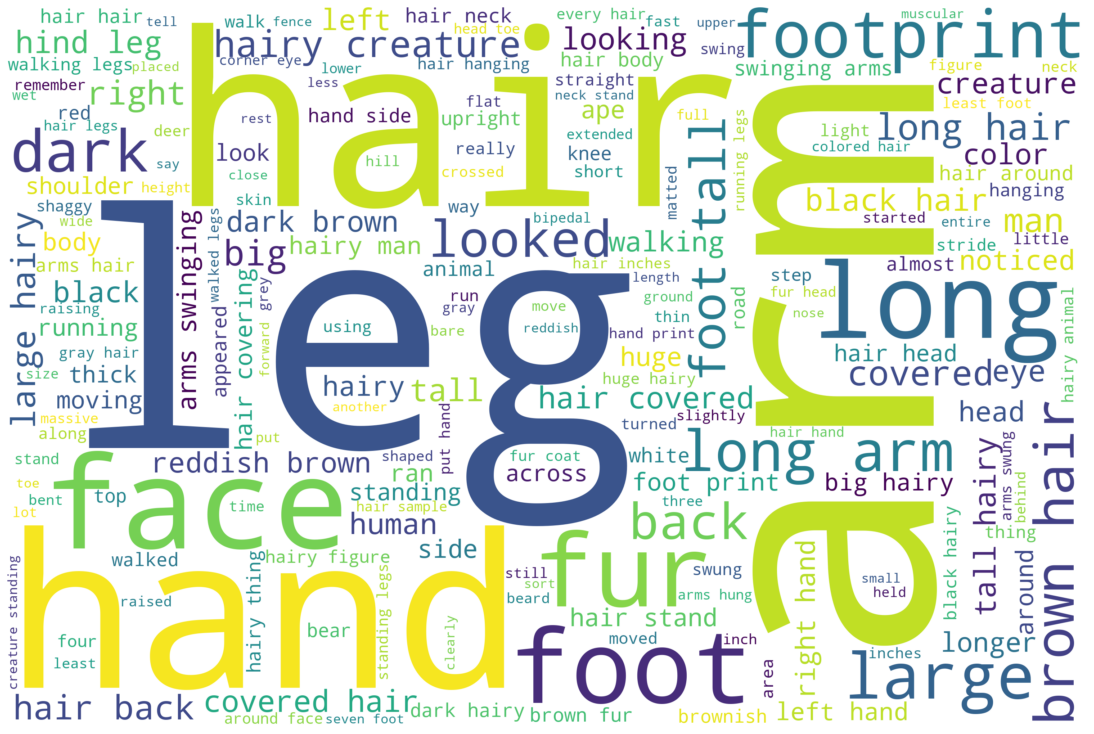

In [ ]:
# Perform a WordCloud using given stopwords.
comment_words = ''
stopwords = set(STOPWORDS)
stopwords.update(['feet','s','never','see','saw','made','seen','two','front','something',
                  'come','stood','tree','maybe','end','said','even','next','us','bit',
                  'go','got','make','came','seen','except','makes','toward','found',
                  'kinda','away','took','much','went','turn','kind','well','one','seemed'])

for vol in narrowed_ob['Observation']:
    vol = str(vol)
    tokens = vol.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 3000, height = 2000,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


plt.figure(figsize = (15, 10), facecolor = None)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

> 
###**Observations:**
As seen in the constructed WordCloud for the appearance attribute of Bigfoot, the most frequent words used in the narrative are:
>
* Long arms and legs
* Dark brown hair
* Long hairy legs
* Hairy creature
* Large

Although we recognize not all descriptive words are associated with Bigfoot, we could rationally associate these narratives with Bigfoot. This is because we paid special attention to designing the keyword we used to select the sentences utilized. Moreover, these selected narratives align with the anticipations of Bigfoot's habitat. For example, since Bigfoot is located in less developed rural areas with low population in colder areas, we could deduce the large size and long fur physical possessions to accommodate such environments.  Thus, we can anticipate that these descriptive words are describing the appearance of Bigfoot, instead of the environment or people. 

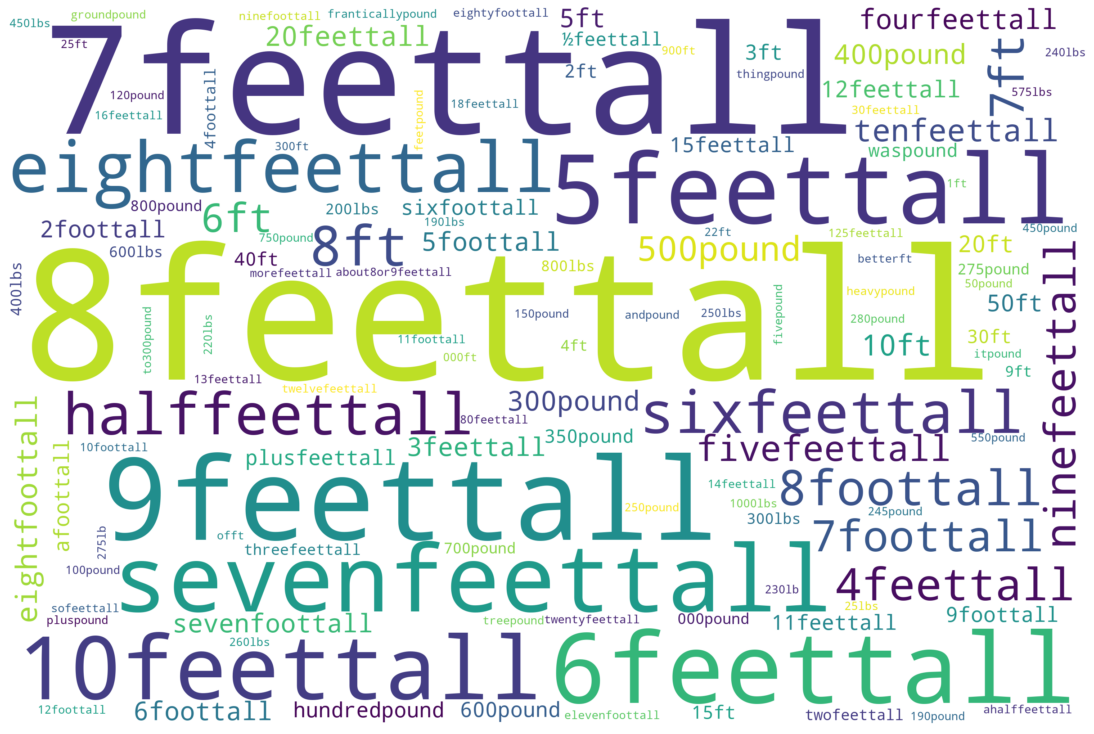

In [ ]:
# Perform a WordCloud in showing the height and weight description
comment_words = ''
for str in no_space['describe']:
    comment_words += ""+ str+","
    
stopwords = set(STOPWORDS)
stopwords.update(['2feettall'])

wordcloud = WordCloud(width = 3000, height = 2000,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (15, 10), facecolor = None)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

As seen in the constructed WordCloud for the weight and height attributes of Bigfoot, there are more observations about the heights compared to the weights. The most frequently appeared narratives are:

>
* 8 to 9 feet tall
* 400-500 pounds

Since the visual inspection of heights is more accurate than weights, the descriptive narrative of height is more reliable than weight. However, based on the overall observation of the size of Bigfoot, we speculate Bigfoot is a tall creature that possesses a masculine figure, which is justified by the observed weight of Bigfoot.

> 
##**Conclusions:**

Based on the WordCloud we had constructed, we can see that Bigfoot is a 5 to 10 feet tall, hairy creature that has long limbs. Bigfoot weighs around 400 to 500 pounds, which explains the reason for the huge footprint it leaves in the reported sightings. We believe it is significantly larger than a normal human being. Furthermore, based on its appearance, we can reasonably deduce that it needs a spacious habitat. Because it is coated with long fur, we anticipate it could survive in more extreme cold climates. 


##**Final Remarks:**

> Based on all the analysis we had performed in this report, our team speculated that Bigfoot is an 8 to 9 feet tall, dark brown creature covered with long hair. It is heavy and masculine and has long limbs. 

> Our geographic analysis indicated that Bigfoot is widely distributed around the Northwest, Midwest, Northeast, and many less-developed locations in the contiguous United States. We observed that Bigfoot sightings are most reported in northern Washington. Therefore, we surmise that Bigfoot is capable of surviving in areas that have relatively extreme or cold climates. 

> Moreover, our comparison analysis reflects that Bigfoot sightings appear mostly in areas with medium to lower per capita income and with lower population rates. Therefore, we further speculate that Bigfoot tends to live in less developed locations with low population density like the rural areas, which intuitively makes logical sense. 

> Finally, there is an overall increasing trend of reported Bigfoot sightings over the years. We do not believe it is due to an increased number of Bigfoot. Instead, as media coverage increased and movies of Bigfoot were released, people are becoming more aware of the mysterious creature, Bigfoot. We believe this is the main reason reports have increased over the years. 

> In order to increase the accuracy and reliability of future studies about Bigfoot using this data, our team urges future researchers to perform analysis on the misinterpretation rate with the Class data. Based on BFRO's online database, each report is assigned a classification: Class A, Class B, or Class C. The variation between the three classifications is related to the potential for misinterpretation of the observed information. Because Class A reports involve clear observation conditions compared to Class B and Class C, the observations reported under Class A convey more accurate and reliable results. 